__Importing the vehicle model__

In [132]:
%run "ev_sub.ipynb"

57.0
126.66666666666667
45
11.739130434782608
1.368
116.53333333333335
156.52173913043475
16.416
104.88000000000002
403.20000000000005
288.0
364.79999999999995
115.19173063162575
0.8315615999999998
1581.5217391304348
1656.5217391304348
555.1020408163266
2211.6237799467613
131.94689145077132


__Importing the cycle data__

In [133]:
cols = ['time','speed']
df = pd.read_csv('us06.txt',delimiter ='\t',header = None, names = cols)
df.drop(index = [0,1], axis = 1, inplace = True)
df.reset_index(drop = True, inplace = True)
df = df.apply(pd.to_numeric)

# Conversion of the speed from mph to m/s
df['speed'] = 1.609344*df['speed']/3.6

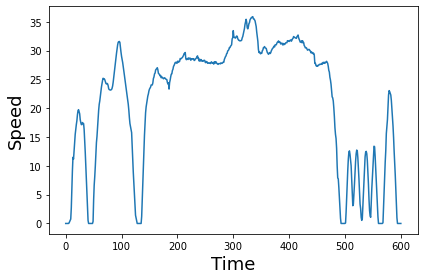

In [134]:
plt.plot(df['time'], df['speed'])

plt.xlabel('Time', size = 18)
plt.ylabel('Speed', size = 18)
plt.tight_layout()
plt.show()

__Incorporating the initial time and speed in DataFrame__


In [135]:
df.loc[0]=[-1,0]

__Defining the road grade__

In [136]:
max_grade = 10*np.pi/180

grade = np.arange(0,max_grade,max_grade/len(df))

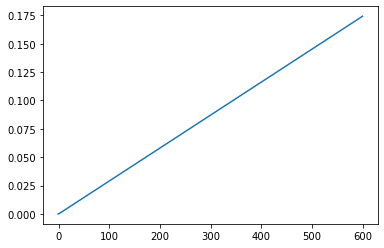

In [137]:
plt.plot(df['time'],grade)
plt.show()

__Calculating the vehicle related parameters__

In [138]:
result = {}

df.head()

,time,speed
0,-1,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


__Defining the variables__

In [139]:
# Vehicle desired speed in m/s
des_speed = np.zeros(len(df))

# Desired acceleration
des_acc = np.zeros(len(df))

# Desired acceleration force
des_acc_force = np.zeros(len(df))

# Aerodynamic force
aero_force = np.zeros(len(df))

# Rolling force on gradient
roll_grade_force = np.zeros(len(df))

# Vehicle torque demand
T_demand = np.zeros(len(df))

# Maximum torque
T_max = np.zeros(len(df))

# Regeneation limit
limit_regen = np.zeros(len(df))

# Limit Torque
T_limit = np.zeros(len(df))

# Motor torque
T_motor = np.zeros(len(df))

# Power demand
P_demand = np.zeros(len(df))

# Limit power
P_limit = np.zeros(len(df))

# Battery demand
demand_battery = np.zeros(len(df))

# Current
current = np.zeros(len(df))

# Battery SOC
bat_SOC = np.zeros(len(df))

# Actual acceleration 
actual_acc = np.zeros(len(df))

# Actual acceleration force
actual_acc_force = np.zeros(len(df))

# Motor speed
speed_motor = np.zeros(len(df))

# Actual speed
actual_speed = np.zeros(len(df))

# Distance
dist = np.zeros(len(df))

__Initializing the variables__

In [140]:
rho = 1.225
des_speed = df['speed']
bat_SOC[0] = p1.soc_full


__Calculating the vehicle parameters__

In [141]:
for i in np.arange(1,len(df),1):
    
    des_acc[i] = (des_speed[i]-des_speed[i-1])/(df['time'][i]-df['time'][i-1])
    des_acc_force [i] = v1.eq_mass()*des_acc[i]
    aero_force[i] = 0.5*rho*v1.cd*v1.farea*actual_speed[i-1]**2
    roll_grade_force[i] = v1.max_weight()*9.81*np.sin(grade[i])
    
    if (actual_speed[i-1] != 0):
        
        roll_grade_force[i] = roll_grade_force[i] + w1.roll_coef*v1.max_weight()*9.81
    
    T_demand[i] = (des_acc_force[i] + aero_force[i] + roll_grade_force[i] \
                   + v1.road_force)*(w1.radius/d1.gear_ratio)
    
    if (speed_motor[i-1] < m1.rated_RPM):
        
        T_max[i] = m1.Tmax
        
    else:
        
        T_max[i] = m1.Tmax*m1.rated_RPM/speed_motor[i-1]
        
    limit_regen[i] = min(T_max[i],d1.T_regen*m1.Tmax)
    T_limit[i] = min(T_demand[i],T_max[i])
    
    if (T_limit[i] > 0):
        
        T_motor[i] = T_limit[i]
    
    else:
        
        T_motor[i] = max(-limit_regen[i],T_limit[i])
        
    actual_acc_force[i] = (T_limit[i]*d1.gear_ratio/w1.radius) \
                            - aero_force[i] \
                            -roll_grade_force[i]-v1.road_force
    
    actual_acc[i] = actual_acc_force[i]/v1.eq_mass()
    
    speed_motor[i] = min(m1.max_RPM, \
                        d1.gear_ratio*\
                        actual_speed[i-1] + actual_acc[i]*\
                        (df['time'][i]-df['time'][i-1])*\
                        (60/(2*np.pi*w1.radius)))
    
    actual_speed[i] = (speed_motor[i]*2*np.pi*w1.radius)/(60*d1.gear_ratio)
    dist [i] = dist[i-1] + 0.5*(actual_speed[i]+actual_speed[i-1])*\
            (df['time'][i]-df['time'][i-1])/1000
    
    if (T_limit[i]  > 0):
        
        P_demand[i] = T_limit[i]
        
    else:
        
        P_demand[i] = max(T_limit[i], -limit_regen[i])
        
    P_demand[i] = P_demand[i]*2*np.pi*0.5* \
        (speed_motor[i] + speed_motor[i-1])/60000
        
    P_limit[i] = max(-m1.max_power(), min(m1.max_power(),P_demand[i]))
    
    demand_battery[i] = v1.p_overhead/1000
    
    if (P_limit[i] > 0):
        
        demand_battery[i] = demand_battery[i] + P_limit[i]/d1.eff()
        
    else:
        
        demand_battery[i] = demand_battery[i] + P_limit[i]*d1.eff()
        

    current[i] = demand_battery[i]*1000/p1.vnom()
    
    bat_SOC[i] = bat_SOC[i-1] - current[i]*(df['time'][i]-df['time'][i-1])/(36*mod.mod_cap()) 
    

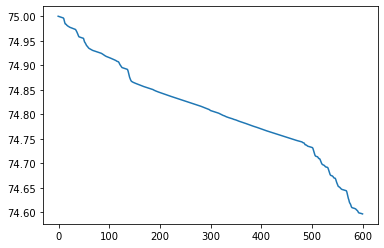

In [142]:


plt.plot(df['time'],bat_SOC)


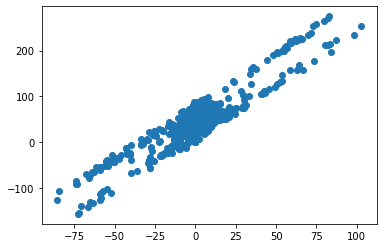

In [143]:
plt.scatter(speed_motor,T_motor)

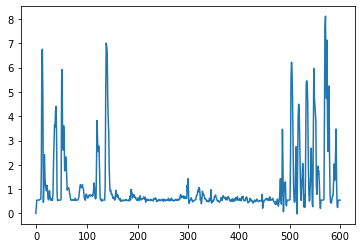

In [144]:
plt.plot(df['time'],current)